In [ ]:
cd ~/3TDisk/Experiments/2D-TAN/

In [2]:
import sys
sys.path.append("./lib")

import os
import math
import argparse
import pickle as pkl

from tqdm import tqdm
import numpy as np
import torch
from torch.utils.data import DataLoader

# import _init_paths
from core.engine import Engine
import datasets
import models
from core.utils import AverageMeter
from core.config import config, update_config
from core.eval import eval_predictions, display_results
import models.loss as loss

In [8]:
import numpy as np
import torch
from torch import nn
from core.config import config
import models.prop_modules as prop_modules
import models.map_modules as map_modules
import models.fusion_modules as fusion_modules


class BlindTAN(nn.Module):
    def __init__(self):
        super(BlindTAN, self).__init__()
        self.map_mask = torch.tensor(
            np.load("lib/models/prop_modules/map_mask.npy")[None, :],
            requires_grad=False)
        self.map_h = nn.Parameter(torch.rand(512, 64, 64) * 2 - 1)
        self.prop_layer = getattr(prop_modules, config.TAN.PROP_MODULE.NAME)(
            config.TAN.PROP_MODULE.PARAMS
        )
        self.fusion_layer = getattr(
            fusion_modules, config.TAN.FUSION_MODULE.NAME
        )(config.TAN.FUSION_MODULE.PARAMS)
        self.map_layer = getattr(map_modules, config.TAN.MAP_MODULE.NAME)(
            config.TAN.MAP_MODULE.PARAMS
        )
        self.pred_layer = nn.Conv2d(config.TAN.PRED_INPUT_SIZE, 1, 1, 1)

    def forward(self, textual_input, textual_mask):
        b_n = textual_input.shape[0]
        map_h = self.map_h.expand(b_n, *self.map_h.shape)
        map_mask = self.map_mask.expand(b_n, *self.map_mask.shape)
        fused_h = self.fusion_layer(
            textual_input, textual_mask, map_h, map_mask
        )
        fused_h = self.map_layer(fused_h, map_mask)
        prediction = self.pred_layer(fused_h) * map_mask
        return prediction, map_mask

In [3]:
update_config("experiments/charades/2D-TAN-16x16-K5L8-conv-BLIND.yaml")
test_dataset = datasets.Charades("test")

In [7]:
model = BlindTAN()

NameError: name 'BlindTAN' is not defined

In [4]:
dataloader = DataLoader(
    test_dataset,
    batch_size=3,
    shuffle=False,
    num_workers=config.WORKERS,
    pin_memory=False,
    collate_fn=datasets.collate_fn,
)

data_iter = iter(dataloader)
sample = data_iter.next()

In [5]:
sample.keys()

dict_keys(['batch_anno_idxs', 'batch_word_vectors', 'batch_txt_mask', 'batch_map_gt', 'batch_duration'])

In [6]:
textual_input = sample["batch_word_vectors"]
textual_mask = sample["batch_txt_mask"]
map_gt = sample["batch_map_gt"]

In [10]:
prediction, _ = model(textual_input, textual_mask)

torch.Size([3, 1, 64, 64])

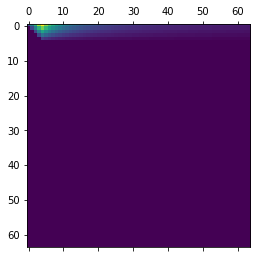

In [12]:
import matplotlib.pyplot as plt
plt.matshow(map_gt[0, 0, :,:].detach().numpy())

In [58]:
prediction[0, 0, :,:]

tensor([[0.0020, 0.0020, 0.0020,  ..., 0.0000, 0.0000, 0.0020],
        [0.0000, 0.0020, 0.0020,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0020,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0020, 0.0020, 0.0020],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0020, 0.0020],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0020]],
       grad_fn=<SliceBackward>)